In [ ]:
!pip install transformers
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  8 00:54:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    61W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm.auto import tqdm

## Initialize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root_dir = "/content/gdrive/My Drive/anya_dna_seq/"

##Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

import pandas as pd
data = f"/{root_dir}/cleaned_non_patho_data_word.txt"
non_patho = pd.read_csv(data, sep=';', header=None)

data = f"/{root_dir}/cleaned_patho_data_word.txt"
patho = pd.read_csv(data, sep=';', header=None)

patho['label'] = 1
non_patho['label'] = 0
samples = pd.concat([patho, non_patho])

# initialize tokenizer with our corpus and vocab created using Tokenizer above
from tokenizers import ByteLevelBPETokenizer
tokenizer = ByteLevelBPETokenizer.from_file(vocab_filename=f"{root_dir}/dna_corpus/vocab.json", 
                                  merges_filename=f"{root_dir}/dna_corpus//merges.txt")
tokenizer.enable_truncation(max_length=1200)
tokenizer.enable_padding()

print(len(patho),len(non_patho))

train_text, temp_text, train_labels, temp_labels = train_test_split(samples[1], samples['label'], 
                                                                    # random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=None)


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=None)


18909 22707


## Testing trained model

In [ ]:
print(samples[1][1])

1    cgtg ctta acac atgc aagt cgaa cggg tctg cctt g...
1    acga acgc tggc ggcg tgct taac acat gcaa gtcg a...
Name: 1, dtype: object


In [ ]:
from transformers import RobertaForMaskedLM

from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=tokenizer.get_vocab_size(),  # we align this to the tokenizer vocab_size
    max_position_embeddings=1200,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
)
config.output_hidden_states=True
dna_model = RobertaForMaskedLM.from_pretrained(f"{root_dir}/dnaBerTo_1200",config=config)
dna_model.config.output_hidden_states=True
## initialize the tokenizer
# from tokenizers import ByteLevelBPETokenizer
# tokenizer = ByteLevelBPETokenizer.from_file(vocab_filename=f"{root_dir}/dna_corpus/vocab.json", 
#                                   merges_filename=f"{root_dir}/dna_corpus//merges.txt")

# tokenizer.enable_truncation(max_length=512)
# tokenizer.enable_padding()

samples = ["atgc aagt cgaa cggg tctg cctt gttt tttg cggg gtgg gtta gtgg cgaa cggg tgag taac acgt gagt aacc tgcc ","actt attg"]
# expected aagg cagg tctc tggg cagt aact gacg ctga ggag cgaa agca tggg tagc gaac agga ttag atac cctg gtag tcca tgcc gtaa
import torch
batch = tokenizer.encode_batch(samples)
labels = torch.tensor([x.ids for x in batch])
mask = torch.tensor([x.attention_mask for x in batch])
# make copy of labels tensor, this will be input_ids
input_ids = labels.detach().clone()
# create random array of floats with equal dims to input_ids
# rand = torch.rand(input_ids.shape)
# # mask random 15% where token is not 0 [PAD], 1 [CLS], or 2 [SEP]
# mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
# # loop through each row in input_ids tensor (cannot do in parallel)
# for i in range(input_ids.shape[0]):
#     # get indices of mask positions from mask array
#     selection = torch.flatten(mask_arr[i].nonzero()).tolist()
#     # mask input_ids
#     input_ids[i, selection] = 3  # our custom [MASK] token == 3
input_ids

tensor([[614, 362, 414, 344, 462, 358, 552, 539, 344, 328, 434, 328, 414, 344,
         361, 366, 456, 417, 425, 376, 225],
        [662, 454,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0]])

In [ ]:
# dna_model.eval()
dna_model.to(device)
# dna_model.config.output_hidden_states=True
for param in dna_model.parameters():
    param.requires_grad = False
# with torch.no_grad():
prediction = dna_model(input_ids.to(device), attention_mask=mask.to(device),
                      labels=labels.to(device))

prediction['loss']
# x = torch.tanh(prediction['hidden_states'][-1])

# print(f"hidden_state {prediction['hidden_states'].shape}")
# print(prediction['logits'].shape)
# prediction = prediction['logits'][1].cpu()
# print(prediction.shape)
# pred_tok = torch.argmax(prediction, dim=-1)
# print(pred_tok.shape)
# print(pred_tok)
# tok = pred_tok.numpy()
# print(f" tok: {tok}")
# predicted_text = tokenizer.decode(tok)
# predicted_text

# prediction = prediction['logits']
# output = torch.argmax(prediction[0]).item()
# tokenizer.decode()
# prediction = prediction[0][0].argmax(dim=-1).item()


tensor(0.0461, device='cuda:0')

## Fine Tune dnaBerTo model for patho/non-patho classification

In [ ]:
## Refer to https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [ ]:
# sample data
text = "atgc aagt cgaa cggg tctg cctt gttt tttg cggg gtgg gtta gtgg cgaa cggg tgag taac acgt gagt aacc tgcc"

# encode text
sent_id = tokenizer.encode(text)

# output
print(sent_id.ids)
tokenizer.decode(sent_id.ids)

[614, 362, 414, 344, 462, 358, 552, 539, 344, 328, 434, 328, 414, 344, 361, 366, 456, 417, 425, 376]


'atgc aagt cgaa cggg tctg cctt gttt tttg cggg gtgg gtta gtgg cgaa cggg tgag taac acgt gagt aacc tgcc'

(1449.362525781374, 499, 2986)

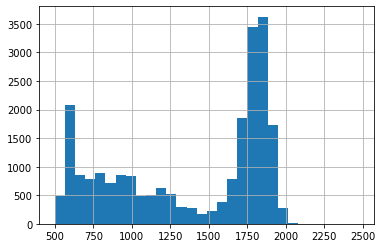

In [ ]:
seq_len = [len(i) for i in non_patho[1]]
pd.Series(seq_len).hist(bins = 30)

lens = [len(s) for s in patho[1]]
avg = sum(lens) / len(lens)
avg,min(lens),max(lens)


<AxesSubplot:>

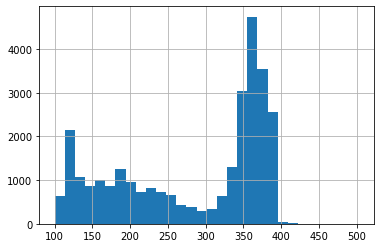

In [ ]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
avg = sum(seq_len) / len(seq_len)
avg,min(seq_len),max(seq_len)

(1376.8840445677545, 499, 2476)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.encode_batch(
    train_text.tolist(),
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.encode_batch(
    val_text.tolist(),
    
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.encode_batch(
    test_text.tolist(),
)

In [ ]:
## convert lists to tensors

train_seq = torch.tensor([x.ids for x in tokens_train])
train_mask = torch.tensor([x.attention_mask for x in tokens_train])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor([x.ids for x in tokens_val])
val_mask = torch.tensor([x.attention_mask for x in tokens_val])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor([x.ids for x in tokens_test])
test_mask = torch.tensor([x.attention_mask for x in tokens_test])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
import torch.nn as nn
class DnaPathoBERT(nn.Module):

    def __init__(self, bert):
      
      super(DnaPathoBERT, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer pool
      self.pool_1 = nn.Linear(768,768)

      # self.pool_2 = nn.tanh(768)

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,1)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)
      # self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      # preds = self.bert(sent_id, attention_mask=mask,labels=sent_id)
      # preds = torch.argmax(preds['logits'], axis = -1).float()
      # print(f'bert shape: {preds.shape}')
      out = self.bert(sent_id, attention_mask=mask,labels=sent_id)
      # print(out)
      out = out['hidden_states'][-1]
      # x = torch.argmax(out, dim=-1)
      # print(f"bert: {out.shape}")

      # x = self.pool_1(out)      
      # print(f"pool_1: {x.shape}")
      
      # x = torch.tanh(x)      
      # print(f"tanh: {x.shape}")
      # x = out['loss']

      x = self.fc1(out)      
      # print(f"fc1: {x.shape}")
      x = self.relu(x)
      # print(f"relu: {x.shape}")
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      # print(f"fc2: {x.shape}")
      # apply softmax activation
      x = self.softmax(x)
      # print(f"softmax: {x.shape}")
      # x = torch.sigmoid(x)
      # print(f"sigmoid: {x.shape}")
      return x

In [ ]:
model = DnaPathoBERT(dna_model)
# push the model to GPU
# model = model.to(device)

# freeze all the parameters
for param in model.bert.parameters():
    param.requires_grad = False

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-4)          # learning rate


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.91342656 1.10470231]


In [ ]:
 #converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss() #weight=weights) 

# number of training epochs
epochs = 10

In [ ]:
# Test the model 
for step,batch in enumerate(train_dataloader):
  # push the batch to gpu
  batch = [r.to(device) for r in batch]
  sent_id, mask, labels = batch
  x = model.bert(sent_id, attention_mask=mask)      
  print(x['hidden_states'][-1].shape)
  model.to(device)
  model.train()
  out = model(sent_id, mask)
  print(out.shape)
  labels = labels.unsqueeze(1)
  print(labels.shape)
  # out = out.squeeze(-1)
  # print(out.shape)
  loss = cross_entropy(out, labels)
  # out = model.bert(sent_id, attention_mask=mask,labels=sent_id)
  # out = out['hidden_states'][-1]
  # x = torch.argmax(out, dim=-1)
  # print(f"bert: {out.shape}")

  # # # x = self.pool_1(out)      
  # # # print(f"pool_1: {x.shape}")

  # x = model.fc1(x)      
  # print(f"fc1: {x.shape}")

  # x = torch.tanh(x)      
  # print(f"tanh: {x.shape}")
  # # x = out['loss']

  # x = self.relu(x)
  # print(f"relu: {x.shape}")
  # x = self.dropout(x)

  # # output layer
  # x = self.fc2(x)
  # print(f"fc2: {x.shape}")
  # # apply softmax activation
  # x = self.softmax(x)
  # print(f"softmax: {x.shape}")

  # x = model(sent_id,mask)
  
  # pred= x # torch.argmax(x, dim=-1)
  # print(f"pred: {pred.shape}")
  # # print(pred)
  # print(f"labels: {labels.shape}")
  # # loss = cross_entropy(pred, labels)
  # print(x)
  break


torch.Size([32, 503, 768])
torch.Size([32, 503, 1])
torch.Size([32, 1])


In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"{root_dir}/logging_dir")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir f"{root_dir}/logging_dir"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25289), started 0:00:53 ago. (Use '!kill 25289' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
# function to train the model
def train(break_after=None):
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  loop = tqdm(train_dataloader, leave=True)
  # iterate over batches
  for step,batch in enumerate(loop):
    # progress update after every 50 batches.
    # if step % 50 == 0 and not step == 0:
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
    # print(sent_id.shape, mask.shape,labels.shape)
    
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # print(preds.shape)
    # print(labels.shape)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels.unsqueeze(1))
    
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    if break_after is not None and step > break_after:
      break

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
batch = val_dataloader.dataset[0:1]
batch = [t.to(device) for t in batch]
sent_id, mask, labels = batch
print(f"sent_id {sent_id.shape}")
print(f"mask {mask.shape}")
print(f"labels {labels.shape}")

model.to(device)
with torch.no_grad():
  print(sent_id.shape)
  preds = model(sent_id, mask)
  # print(f"preds {preds.shape}")
  # print(f"labels {labels.shape}")


sent_id torch.Size([1, 598])
mask torch.Size([1, 598])
labels torch.Size([1])
torch.Size([1, 598])


In [ ]:
# function for evaluating the model
def evaluate():
  
  # print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  loop = tqdm(val_dataloader, leave=True)
  # iterate over batches
  for step,batch in enumerate(loop):
    
    # Progress update every 50 batches.
    # if step % 50 == 0 and not step == 0:
      
      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      # print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels.unsqueeze(1))

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

Main Training Loop

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
#for each epoch
for epoch in tqdm(range(epochs)):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'{root_dir}/dnaBerTo_1200/weights_epoch10.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/valid", valid_loss, epoch)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    writer.flush()
writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 1 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.714
Validation Loss: 0.478

 Epoch 2 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.520
Validation Loss: 0.421

 Epoch 3 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.474
Validation Loss: 0.402

 Epoch 4 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.450
Validation Loss: 0.395

 Epoch 5 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.427
Validation Loss: 0.383

 Epoch 6 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.416
Validation Loss: 0.371

 Epoch 7 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.405
Validation Loss: 0.363

 Epoch 8 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.397
Validation Loss: 0.363

 Epoch 9 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.388
Validation Loss: 0.354

 Epoch 10 / 10


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]


Training Loss: 0.381
Validation Loss: 0.357


In [ ]:
model.load_state_dict(torch.load(f'{root_dir}/dnaBerTo_1200/weights_epoch10.pt'))

<All keys matched successfully>

In [ ]:
test_len = len(test_seq)

In [ ]:
import numpy as np
model.to(device)
from sklearn.metrics import classification_report
batch_size = 128
count = 0
pred_total = None
for i in range(0,test_len,batch_size):
  seq,mask = test_seq[i:i+batch_size],test_mask[i:i+batch_size]
  preds = model(seq.to(device),mask.to(device))
  # print(preds.shape)
  if pred_total is None:
    pred_total = preds
  else:
    pred_total = torch.cat((pred_total,preds),dim=0)
    # print(pred_total.shape)

# print(pred_total.shape)  

# get predictions for test data
# with torch.no_grad():
  
#   preds = model(test_seq.to(device), test_mask.to(device))
#   preds = preds.detach().cpu().numpy()
preds = pred_total.detach().cpu().numpy()
print(preds.shape)
print(len(test_y))
preds = np.argmax(preds, axis = 1)
print(preds.shape)
print(classification_report(test_y, np.squeeze(preds)))

(6243, 488, 1)
6243
(6243, 1)
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3359
           1       0.83      0.83      0.83      2884

    accuracy                           0.84      6243
   macro avg       0.84      0.84      0.84      6243
weighted avg       0.84      0.84      0.84      6243



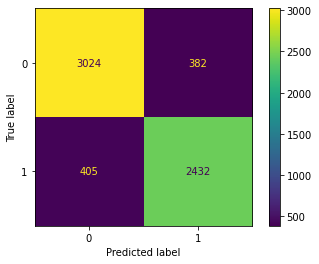

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, np.squeeze(preds))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm, display_labels=np.arange(2)).plot()

In [ ]:
def get_accuracy(pred, actual):
  assert len(pred) == len(actual)

  total = len(actual)
  # _, predicted = torch.max(pred.data, 1)
  correct = (pred == actual).sum().item()
  return correct / total

acc = get_accuracy(torch.Tensor(np.squeeze(preds)),torch.Tensor(test_y))
acc

0.8739388114688451

In [ ]:
sample = "tcag gacg gacg ctgg cggc gtgc ttaa caca tgca agtc gaac ggaa aggc ctag cttg ctag gtac tcga gtgg cgaa cggg tgag taac acgt gggt gatc tgcc tcgt actt cggg ataa gcct ggga aact gggt ctaa tact ggat agga ccat gctt tagt gtgt gtgg tgga aagt tttt cggt acga gatg agcc cgcg gcct atca gctt gttg gtgg ggta atgg ccta ccaa ggcg tcga cggg tagc cggc ctga gagg gtgg acgg ccac attg ggac tgag atac ggcc caga ctcc tacg ggag gcag cagt gggg aata ttgc acaa tggg cgca agcc tgat gcag cgac gccg cgtg gggg atga cggc cttc gggt tgta aacc tctt tcgc tagg gacg aagc tttt gtga cggt acct agat aaga agca ccgg ctaa ctac gtgc cagc agcc gcgg taat acgt aggg tgcg agcg ttgt ccgg aatt actg ggcg taaa gagc tcgt aggt ggtt tgtc gcgt cgtc tgtg aaat tccg gggc ttaa cttc gggc gtgc aggc gata cggg cata actt gagt gctg tagg ggag actg gaat tcct ggtg tagc ggtg gaat gcgc agat atca ggag gaac accg atgg cgaa ggca ggtc tctg ggca gtaa ctga cgct gagg agcg aaag catg ggga gcga acag gatt agat accc tggt agtc catg ccgt aaac ggtg ggcg ctag gtgt gagg gtct tcca cgac tttc gtgc cgta gcta acgc atta agcg cccc gcct gggg agta cggc cgca aggc taaa actc aaag gaat tgac gggg gccc gcac aagc ggcg gagc atgt ggat taat tcga tgca acgc gaag aacc ttac ctgg gctt gaca tatg cagg atcg gcgt agtg atac gttt tccc ttgt ggtc tgta taca ggtg gtgc atgg ttgt cgtc agct cgtg tcgt gaga tgtt gggt taag tccc gcaa cgag cgca accc ttgt ctta tgtt gcca gcac gtga tggt gggg actc atga gaga ctgc cggg gtta actc ggag gaag gtgg ggat gacg tcaa atca tcat gccc ctta tgtc cagg gctt caca catg ctac aatg gtcg gtac aacg cgct gcga gcct gtga gggt gagc gaat cgct gaaa gccg gcct cagt tcgg attg gggt ctgc aact cgac ccca tgaa gtcg gagt cgct agta atcg caga tcag caac gctg cggt gaat acgt nccc gggc cttg taca cacc gccc gtca cgtc atga aagt tggt aaca cccg aagc cagt ggcc taac cctt gtgg gggg gagc tgtc gaag gtgg natc ggcg attg gnac gaag tcgt aaca aggt agcc gtac cgga aggt gcgg gctg"
sample_tok = tokenizer.encode(sample)

In [ ]:
model.to(device)
loss = model(torch.tensor([sample_tok.ids]).to(device),torch.tensor([sample_tok.attention_mask]).to(device)).detach().cpu()

In [ ]:
import numpy as np

# loss = loss.numpy()
loss = np.argmax(loss, axis = 1)
loss = loss[0].item()
print(loss)

1


In [ ]:
model.bert

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(2163, 768, padding_idx=1)
      (position_embeddings): Embedding(1200, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [ ]:
prediction['hidden_states'][-1].shape

torch.Size([2, 21, 768])